In [ ]:
!pip install fastmri
!pip install pandasql

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

PATH = 'drive/MyDrive'
REPO_PATH = PATH + '/fastMRI'
DATA_PATH = PATH + '/datasets'
ANNOTATION_PATH = REPO_PATH + '/Annotations/knee.csv'

Mounted at /content/drive/


In [ ]:
%matplotlib inline
import sys
import h5py
import numpy as np
import pandas as pd
from pandasql import sqldf
import seaborn as sns

from PIL import ImageDraw, Image, ImageEnhance
from matplotlib import pyplot as plt
from pathlib import Path
import cv2
import fastmri
from fastmri.data import transforms as T

#### Exploratory Analysis of Annotations

In [ ]:
# Import dataset
file_path = Path(DATA_PATH + '/singlecoil_train')
file_list = list(file_path.glob('**/*.h5'))

df = pd.read_csv(ANNOTATION_PATH, index_col=None, header=0)

# test with 1 file
labels_for_file = df.loc[df['file'] == 'file1000001']
labels_for_file['label'].unique()

array(['Cartilage - Partial Thickness loss/defect',
       'Bone- Subchondral edema', 'Ligament - MCL Low-Mod Grade Sprain',
       'Cartilage - Full Thickness loss/defect', 'Meniscus Tear',
       'Periarticular cysts'], dtype=object)

In [ ]:
# Get Number of instances of multiple bounding boxes of the same symptom on the same slice
q = """
SELECT NumBoxes, COUNT(*) AS NumInstances FROM
(
  SELECT Label, File, Slice, COUNT(*) AS NumBoxes FROM df
  GROUP BY 1,2,3
)
GROUP BY 1 ORDER BY 1
"""
sqldf(q, globals())

In [ ]:
q = """
WITH
  BoundingBoxes AS
  (
    SELECT
        ROW_NUMBER() OVER(ORDER BY File,Label,Slice) AS BoxId
      , File, Label, Slice, Width, Height
      , Width * Height AS Area
      , x, y
      , x AS x0, x + width  AS x1
      , y AS y0, y + height AS y1
    FROM df
  )

, BoundingBoxes_1PerSlice AS
  (
    SELECT * FROM
    (
      SELECT *, ROW_NUMBER() OVER(PARTITION BY File, Label, Slice ORDER BY Area DESC) AS AreaRank
      FROM BoundingBoxes
    )
    WHERE AreaRank = 1
  )

, Pathology AS
  (
    SELECT *,
      Slice - ROW_NUMBER() OVER(PARTITION BY File, Label ORDER BY Slice) AS PathologyId
    FROM BoundingBoxes_1PerSlice
  )

SELECT
    File, Label, PathologyId
  , MIN(Slice)                AS FromSlice
  , AVG(Slice)                AS MeanSlice
  , MAX(Slice)                AS ToSlice
  , MAX(Slice) -MIN(Slice) +1 AS Depth
  , MAX(Width)                AS Width
  , MAX(Height)               AS Height
FROM
    Pathology
GROUP BY
    File, Label, PathologyId
ORDER BY
    Label
"""

pathology = sqldf(q, globals())

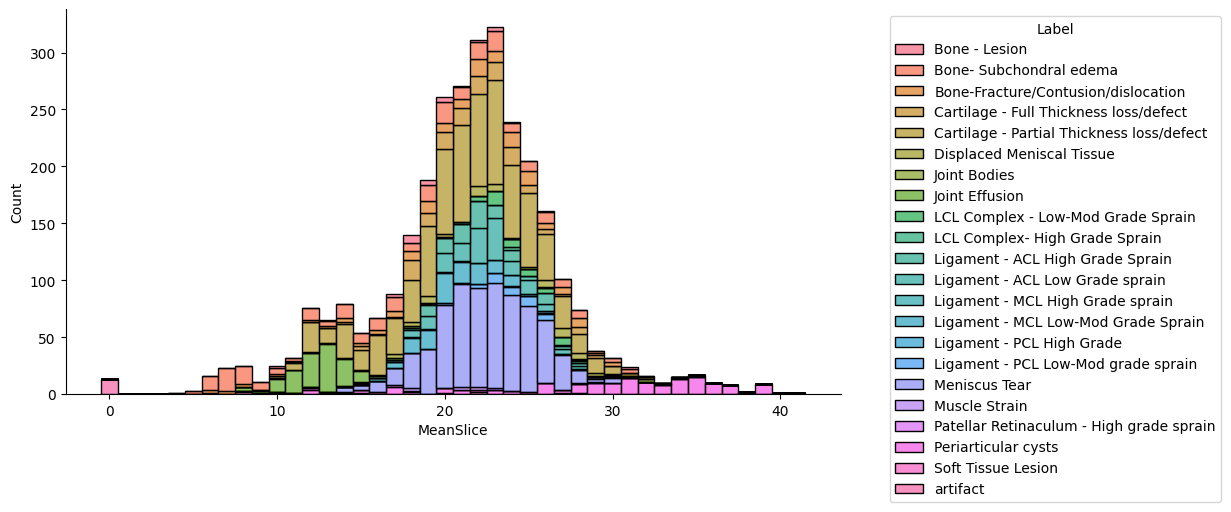

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(
    pathology,
    x="MeanSlice", hue="Label",
    multiple="stack", discrete = True
)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.5, 1))

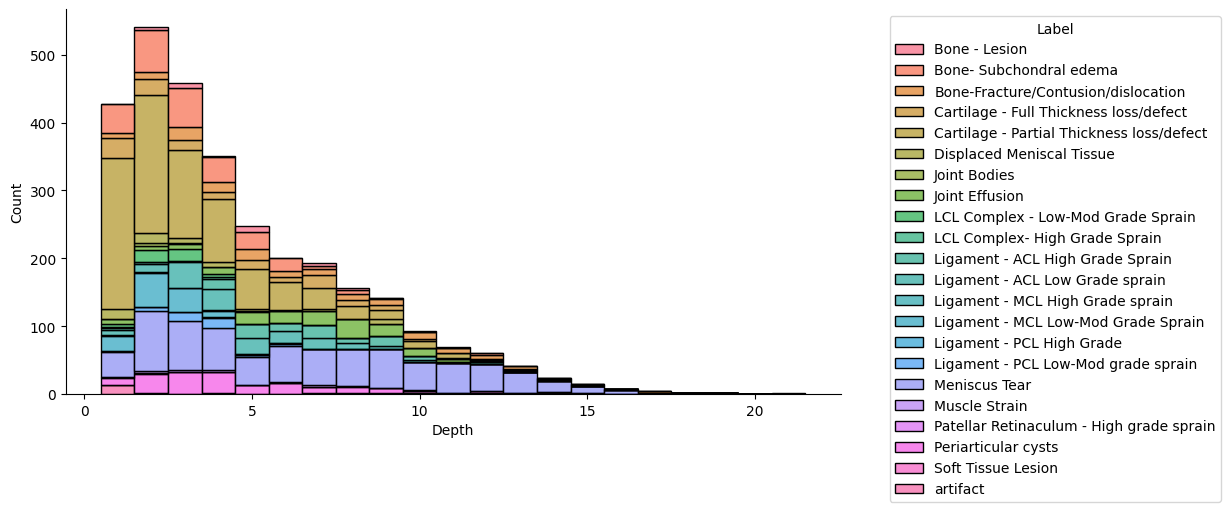

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(
    pathology,
    x="Depth", hue="Label",
    multiple="stack", discrete = True
)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.5, 1))

#### Write to h5 File (WIP)

In [ ]:
# Choose .h5 file
file_name = file_list[2]
hf = h5py.File(f,'r')

In [ ]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)


def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPD_FBK', 'max': 0.0005279243318006589, 'norm': 0.13987833628235666, 'patient_id': 'b0f3e92017c64a54728ffb909ecb66e9e0bf8ca08f7f5aa710add1a56a0905dd'}
complex64
(35, 640, 372)


In [ ]:
slice_kspace2 = T.to_tensor(slice_kspace)           # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)         # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)  # Compute absolute value to get a real image
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')